# The Deep Parametric PDE Method
James Watson | University of Sussex | August 2025



---

### Original code from Linus Wunderlich and jww Kathrin Glau (2020) for a 2-asset basket option under Black-Scholes dynamics:

Reference [52] in report: GitHub: https://github.com/LWunderlich/DeepPDE/blob/main/TwoAssetsExample/DeepParametricPDEExample.ipynb

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K

from tensorflow import keras
from scipy.stats import norm
from numpy.polynomial.hermite import hermgauss

import matplotlib.pyplot as plt

import urllib
import os

np.random.seed(42)

In [86]:
load_model = False
nr_samples_surface_plot = 21
nr_samples_scatter_plot = 1000
nr_samples_error_calculation = 10000

In [87]:
# Model parameters. Re-train model after any changes.
s_min_interest = 25
s_max_interest = 150
t_min_interest = 0.5
t_max_interest = 4.

riskfree_rate_min = 0.1
riskfree_rate_max = 0.3
riskfree_rate_eval = 0.2

volatility_min = 0.1
volatility_max = 0.3
volatility1_eval = 0.1
volatility2_eval = 0.3

correlation_min = 0.2
correlation_max = 0.8
correlation_eval = 0.5

strike_price = 100

In [88]:
nr_nodes_per_layer = 90
initial_learning_rate = 0.001
localisation_parameter = 1/10.

n_train = 10000
nr_epochs = 50

In [89]:
dimension_state = 2
dimension_parameter = 4
dimension_total = 1 + dimension_state + dimension_parameter

t_min = 0.
t_max = t_max_interest
s_max = strike_price * (1 + 3*volatility_max*t_max)
x_max = np.log(s_max)
x_min = 2*np.log(strike_price) - x_max

normalised_max = 1
normalised_min = -1

def transform_ab_to_cd(x, a, b, c, d): 
    """
    Perform a linear transformation of a scalar from the souce interval
    to the target interval.

    Keyword arguments:
    x -- scalar point(s) to transform
    a, b -- interval to transform from
    c, d -- interval to transform to 
    """
    return c + (x-a) * (d-c) / (b-a)

def transform_to_logprice(x): 
    """ Transform normalised variable to the log-price. """
    return transform_ab_to_cd(x, normalised_min, normalised_max, x_min, x_max)

def transform_to_time(t): 
    """ Transform normalised variable to the time variable. """
    return transform_ab_to_cd(t, normalised_min, normalised_max, t_min, t_max)

def normalise_logprice(x):
    """ Transform log-price to its corresponding normalised variable. """
    return transform_ab_to_cd(x, x_min, x_max, normalised_min, normalised_max)

def normalise_time(t): 
    """ Transform time to its corresponding normalised variable. """
    return transform_ab_to_cd(t, t_min, t_max, normalised_min, normalised_max)

t_min_interest_normalised = normalise_time(t_min_interest)
t_max_interest_normalised = normalise_time(t_max_interest)

diff_dx = (normalised_max-normalised_min) / (x_max-x_min) 
diff_dt = (normalised_max-normalised_min) / (t_max-t_min)

def transform_to_riskfree_rate(mu_1):
    """ Transform normalised variable to the risk-free rate. """
    return transform_ab_to_cd(mu_1, normalised_min, normalised_max,
                                    riskfree_rate_min, riskfree_rate_max)

def transform_to_volatility(mu_2):
    """ Transform normalised variable to the volatility. """
    return transform_ab_to_cd(mu_2, normalised_min, normalised_max,
                                    volatility_min, volatility_max)
    
def transform_to_correlation(mu_3):
    """ Transform normalised variable to the correlation. """
    return transform_ab_to_cd(mu_3, normalised_min, normalised_max,
                                    correlation_min, correlation_max)

def normalise_riskfree_rate(riskfree_rate):
    """ Transform risk-free rate to its corresponding normalised variable. """
    return transform_ab_to_cd(riskfree_rate,
                              riskfree_rate_min, riskfree_rate_max, 
                              normalised_min, normalised_max)
    
def normalise_volatility(volatility):
    """ Transform volatility to its corresponding normalised variable. """
    return transform_ab_to_cd( volatility, volatility_min, volatility_max,
                                            normalised_min, normalised_max)
    
def normalise_correlation(correlation):
    """ Transform correlation to its corresponding normalised variable. """
    return transform_ab_to_cd(correlation, correlation_min, correlation_max,
                                            normalised_min, normalised_max)


riskfree_rate_eval_normalised = normalise_riskfree_rate(riskfree_rate_eval)
volatility1_eval_normalised = normalise_volatility(volatility1_eval)
volatility2_eval_normalised = normalise_volatility(volatility2_eval)
correlation_eval_normalised = normalise_correlation(correlation_eval)

In [90]:
class HighwayLayer(keras.layers.Layer):
    """ Define one layer of the highway network. """

    def __init__(self, units=50, original_input=dimension_total):
        """ Construct the layer by creating all weights and biases in keras. """ 
        super(HighwayLayer, self).__init__()
        self.units = units

        # create all weights and biases
        self.Uz = self.add_weight("Uz", shape=(original_input, self.units),
                                    initializer="random_normal", trainable=True)
        self.Ug = self.add_weight("Ug", shape=(original_input, self.units),
                                    initializer="random_normal", trainable=True)
        self.Ur = self.add_weight("Ur", shape=(original_input, self.units),
                                    initializer="random_normal", trainable=True)
        self.Uh = self.add_weight("Uh", shape=(original_input, self.units),
                                    initializer="random_normal", trainable=True)
        
        self.Wz = self.add_weight("Wz", shape=(self.units, self.units),
                                    initializer="random_normal", trainable=True)
        self.Wg = self.add_weight("Wg", shape=(self.units, self.units),
                                    initializer="random_normal", trainable=True)
        self.Wr = self.add_weight("Wr", shape=(self.units, self.units),
                                    initializer="random_normal", trainable=True)
        self.Wh = self.add_weight("Wh", shape=(self.units, self.units),
                                    initializer="random_normal", trainable=True)
        
        self.bz = self.add_weight("bz", shape=(self.units,), 
                                  initializer="random_normal", trainable=True)
        self.bg = self.add_weight("bg", shape=(self.units,), 
                                  initializer="random_normal", trainable=True)
        self.br = self.add_weight("br", shape=(self.units,), 
                                  initializer="random_normal", trainable=True)
        self.bh = self.add_weight("bh", shape=(self.units,), 
                                  initializer="random_normal", trainable=True)

    def call(self, input_combined):
        """ Returns the result of the layer calculation.
        
        Keyord arguments:
        input_combined -- Dictionary containing the original input of 
        the neural network as 'original_variable' and 
        the output of the previous layer as 'previous layer'.
        """
        previous_layer = input_combined['previous_layer']
        original_variable = input_combined['original_variable']

        # Evaluate one layer using the weights created by the constructor
        Z = tf.keras.activations.tanh(
            tf.matmul(original_variable, self.Uz)
            + tf.matmul(previous_layer,self.Wz) 
            + self.bz)
        
        G = tf.keras.activations.tanh(
            tf.matmul(original_variable, self.Ug) 
            + tf.matmul(previous_layer,self.Wg) 
            + self.bg)
        
        R = tf.keras.activations.tanh(
            tf.matmul(original_variable, self.Ur) 
            + tf.matmul(previous_layer,self.Wr) 
            + self.br)
      
        SR = tf.multiply(previous_layer, R)

        H = tf.keras.activations.tanh(
            tf.matmul(original_variable, self.Uh) 
            + tf.matmul(SR, self.Wh) 
            + self.bh)
        
        one_minus_G = tf.ones_like(G) - G

        return tf.multiply(one_minus_G, H) + tf.multiply(Z, previous_layer)

In [91]:
def create_network(inputs):
    """ Creates the neural network by creating three highway layers and an 
    output layer. Returns the output of these layers as a tensorflow variable.

    Keyword arguments:
    inputs -- Tensorflow variable of the input layer
    """
    layer0 = keras.layers.Dense(nr_nodes_per_layer, activation="tanh")

    layer1 = HighwayLayer(units=nr_nodes_per_layer,
                          original_input=dimension_total)
    layer2 = HighwayLayer(units=nr_nodes_per_layer,
                          original_input=dimension_total)
    layer3 = HighwayLayer(units=nr_nodes_per_layer,
                          original_input=dimension_total)
    
    last_layer = keras.layers.Dense(1)

    outputs_layer0 = layer0(inputs)
    outputs_layer1 = layer1({'previous_layer': outputs_layer0, 
                             'original_variable': inputs})
    outputs_layer2 = layer2({'previous_layer': outputs_layer1, 
                             'original_variable': inputs})
    outputs_layer3 = layer3({'previous_layer': outputs_layer2, 
                             'original_variable': inputs})

    outputs_dnn = last_layer(outputs_layer3)
    
    inputs_t_normalised = inputs[:, 0:1]
    inputs_x1_normalised = inputs[:, 1:2]
    inputs_x2_normalised = inputs[:, 2:3]
    inputs_p1_normalised = inputs[:, 3:4]
    
    inputs_t = transform_to_time(inputs_t_normalised)
    inputs_x1 = transform_to_logprice(inputs_x1_normalised)
    inputs_x2 = transform_to_logprice(inputs_x2_normalised)
    inputs_s_mean = (tf.math.exp(inputs_x1) + tf.math.exp(inputs_x2))/2.
    riskfree_rate = transform_to_riskfree_rate(inputs_p1_normalised)

    localisation = tf.math.log(1+tf.math.exp(localisation_parameter * (
            inputs_s_mean - strike_price * tf.exp( - riskfree_rate * inputs_t)
              )))/localisation_parameter

    return outputs_dnn + localisation

In [92]:
class DPDEGenerator(keras.utils.Sequence):
    """ Create batches of random points for the network training. """

    def __init__(self, batch_size):
        """ Initialise the generator by saving the batch size. """
        self.batch_size = batch_size
      
    def __len__(self):
        """ Describes the number of points to create """
        return self.batch_size
    
    def __getitem__(self, idx):
        """ Get one batch of random points in the interior of the domain to 
        train the PDE residual and with initial time to train the initial value.
        """
        data_train_interior = np.random.uniform(
            normalised_min, normalised_max, [self.batch_size, dimension_total]) 

        t_train_initial = normalised_min * np.ones((self.batch_size, 1))
        s_and_p_train_initial = np.random.uniform(
            normalised_min, normalised_max,
            [self.batch_size, dimension_state + dimension_parameter])
        
        data_train_initial = np.concatenate(
            (t_train_initial, s_and_p_train_initial), axis=1)

        return [data_train_interior, data_train_initial]

In [93]:
class DPDEModel(keras.Model):
    """ Create a keras model with the deep param. PDE loss function """

    def train_step(self, data):
        """ Create one optimisation stop based on the deep param. PDE loss function. """
        data_interior, data_initial = data

        riskfree_rate_interior = transform_to_riskfree_rate(
            data_interior[:, 3:4])
        volatility1_interior = transform_to_volatility(data_interior[:, 4:5])
        volatility2_interior = transform_to_volatility(data_interior[:, 5:6])
        correlation_interior = transform_to_correlation(data_interior[:, 6:7])

        x1_initial = transform_to_logprice(data_initial[:, 1:2])
        x2_initial = transform_to_logprice(data_initial[:, 2:3])

        with tf.GradientTape() as tape:
            v_interior = self(data_interior, training=True)  # Forward pass
            v_initial = self(data_initial, training=True)  # Forward pass bdry

            gradient = K.gradients(v_interior, data_interior)[0]

            v_dt = diff_dt * gradient[:, 0:1]
            v_dx1 = diff_dx * gradient[:, 1:2]
            v_dx2 = diff_dx * gradient[:, 2:3]

            grad_v_dx1 = K.gradients(v_dx1, data_interior)[0]
            grad_v_dx2 = K.gradients(v_dx2, data_interior)[0]

            v_dx1dx1 = diff_dx * grad_v_dx1[:, 1:2]
            v_dx2dx2 = diff_dx * grad_v_dx2[:, 2:3]
            v_dx1dx2 = diff_dx * grad_v_dx1[:, 2:3]
            v_dx2dx1 = diff_dx * grad_v_dx2[:, 1:2]

            residual_interior = (
                v_dt + riskfree_rate_interior * v_interior 
                - (riskfree_rate_interior - volatility1_interior**2/2) * v_dx1
                - (riskfree_rate_interior - volatility2_interior**2/2) * v_dx2
                - 0.5 * volatility1_interior**2 * v_dx1dx1
                - 0.5 * volatility2_interior**2 * v_dx2dx2 
                - 0.5 * correlation_interior 
                    * volatility1_interior * volatility2_interior * v_dx1dx2 
                - 0.5 * correlation_interior 
                    * volatility2_interior * volatility1_interior * v_dx2dx1
                )

            s_mean_initial = 0.5 * (
                tf.math.exp(x1_initial)+tf.math.exp(x2_initial)) 
            payoff_initial = K.maximum(s_mean_initial - strike_price, 0)

            loss_interior = K.mean(K.square(residual_interior))
            loss_initial = K.mean(K.square(v_initial - payoff_initial))
            
            loss = loss_initial + loss_interior

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        return {"loss": loss, 
                "loss initial": loss_initial, 
                "loss interior": loss_interior}
        

In [94]:
%%time
if load_model:
    # Load model from local folder. If it is not availabe, download it.
    os.makedirs('model/variables', exist_ok=True)
    url_base = 'https://github.com/LWunderlich/DeepPDE/raw/main/TwoAssetsExample/'
    filename = 'model/saved_model.pb'
    if not os.path.isfile(filename):
        urllib.request.urlretrieve(url_base + filename, filename)
        
    filename = 'model/variables/variables.data-00000-of-00001'
    if not os.path.isfile(filename):
        urllib.request.urlretrieve(url_base + filename, filename)

    filename = 'model/variables/variables.index'
    if not os.path.isfile(filename):
        urllib.request.urlretrieve(url_base + filename, filename)

    model = keras.models.load_model('model')   
else:
    # Create and train model from scratch. 
    inputs = keras.Input(shape=(dimension_total,))
    outputs = create_network(inputs)
    model = DPDEModel(inputs=inputs, outputs=outputs)
    batch_generator = DPDEGenerator(n_train)
    model.compile(optimizer=tf.keras.optimizers.Adam(initial_learning_rate))
    callback = tf.keras.callbacks.EarlyStopping(
        'loss', patience=50, restore_best_weights=True)
    
    model.fit(x=batch_generator, epochs=nr_epochs, steps_per_epoch=10,
                          callbacks=[callback])

Epoch 1/50
10/10 [==============================] - 23s 100ms/step - loss: 2.9030 - loss initial: 2.4191 - loss interior: 0.4839
Epoch 2/50
10/10 [==============================] - 1s 99ms/step - loss: 2.5363 - loss initial: 2.0902 - loss interior: 0.4461
Epoch 3/50
10/10 [==============================] - 1s 107ms/step - loss: 2.4036 - loss initial: 1.9887 - loss interior: 0.4148
Epoch 4/50
10/10 [==============================] - 1s 105ms/step - loss: 1.9361 - loss initial: 1.5779 - loss interior: 0.3582
Epoch 5/50
10/10 [==============================] - 1s 108ms/step - loss: 1.5111 - loss initial: 1.1486 - loss interior: 0.3625
Epoch 6/50
10/10 [==============================] - 1s 119ms/step - loss: 1.1544 - loss initial: 0.7913 - loss interior: 0.3631
Epoch 7/50
10/10 [==============================] - 2s 155ms/step - loss: 0.7735 - loss initial: 0.4482 - loss interior: 0.3253
Epoch 8/50
10/10 [==============================] - 2s 165ms/step - loss: 0.5566 - loss initial: 0.2181 

---

# Extended to 10-Asset Basket Option Under Black-Scholes

In [8]:
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K

from tensorflow import keras

np.random.seed(42)

# Model parameters
s_min_interest = 0.01
s_max_interest = 100
t_min_interest = 0.01
t_max_interest = 1.

riskfree_rate_min = 0.01
riskfree_rate_max = 0.2
riskfree_rate_eval = 0.05

volatility_min = 0.1
volatility_max = 0.3
volatilities_eval = [0.1, 0.2, 0.15, 0.25, 0.18, 0.22, 0.16, 0.19, 0.21, 0.23]

correlation_min = 0.1
correlation_max = 0.7
correlations_eval = [0.2] * 45

strike_price = 50

# Network parameters
nr_nodes_per_layer = 90
initial_learning_rate = 0.0001
localisation_parameter = 1/50. # Reduced from 1/25 to enable stability 

load_model = False
nr_samples_surface_plot = 21
nr_samples_scatter_plot = 1000
nr_samples_error_calculation = 1000 # reduced from 10,000

# Training parameters
n_train = 1000
nr_epochs = 250

# Dimensions for 10 assets
dimension_state = 10 # 10 log-prices 
n_assets = dimension_state 

## 45 correlations 
###  upper triangle of correlation matrix (row 1: 9 correlation, row 2: 8 correlations, ..., row 9: 1 correlation. Total = 9 + 8 +, ..., +1)
n_correlations = n_assets * (n_assets - 1) // 2 

dimension_parameter = 1 + n_assets + n_correlations # 1 + 10 + 45 = 56
dimension_total = 1 + dimension_state + dimension_parameter # Total dimension = 1 + 10 + 56 = 67

# Domain setup
t_min = 0.
t_max = t_max_interest
s_max = strike_price * (1 + 3*volatility_max*t_max)
x_max = np.log(s_max)
x_min = 2*np.log(strike_price) - x_max

normalised_max = 1
normalised_min = -1

# Transformation functions
def transform_ab_to_cd(x, a, b, c, d): 
    return c + (x-a) * (d-c) / (b-a)

def transform_to_logprice(x): 
    return transform_ab_to_cd(x, normalised_min, normalised_max, x_min, x_max)

def transform_to_time(t): 
    return transform_ab_to_cd(t, normalised_min, normalised_max, t_min, t_max)

def normalise_logprice(x):
    return transform_ab_to_cd(x, x_min, x_max, normalised_min, normalised_max)

def normalise_time(t): 
    return transform_ab_to_cd(t, t_min, t_max, normalised_min, normalised_max)

t_min_interest_normalised = normalise_time(t_min_interest)
t_max_interest_normalised = normalise_time(t_max_interest)

diff_dx = (normalised_max-normalised_min) / (x_max-x_min) 
diff_dt = (normalised_max-normalised_min) / (t_max-t_min)

def transform_to_riskfree_rate(mu_1):
    return transform_ab_to_cd(mu_1, normalised_min, normalised_max,
                                    riskfree_rate_min, riskfree_rate_max)

def transform_to_volatility(mu_2):
    return transform_ab_to_cd(mu_2, normalised_min, normalised_max,
                                    volatility_min, volatility_max)
    
def transform_to_correlation(mu_3):
    return transform_ab_to_cd(mu_3, normalised_min, normalised_max,
                                    correlation_min, correlation_max)

def normalise_riskfree_rate(riskfree_rate):
    return transform_ab_to_cd(riskfree_rate,
                              riskfree_rate_min, riskfree_rate_max, 
                              normalised_min, normalised_max)
    
def normalise_volatility(volatility):
    return transform_ab_to_cd(volatility, volatility_min, volatility_max,
                                            normalised_min, normalised_max)
    
def normalise_correlation(correlation):
    return transform_ab_to_cd(correlation, correlation_min, correlation_max,
                                            normalised_min, normalised_max)

riskfree_rate_eval_normalised = normalise_riskfree_rate(riskfree_rate_eval)
volatilities_eval_normalised = [normalise_volatility(v) for v in volatilities_eval]
correlations_eval_normalised = [normalise_correlation(c) for c in correlations_eval]

# Neural network components
class HighwayLayer(keras.layers.Layer):
    def __init__(self, units=50, original_input=dimension_total):
        super(HighwayLayer, self).__init__()
        self.units = units

        self.Uz = self.add_weight("Uz", shape=(original_input, self.units),
                                    initializer="random_normal", trainable=True)
        self.Ug = self.add_weight("Ug", shape=(original_input, self.units),
                                    initializer="random_normal", trainable=True)
        self.Ur = self.add_weight("Ur", shape=(original_input, self.units),
                                    initializer="random_normal", trainable=True)
        self.Uh = self.add_weight("Uh", shape=(original_input, self.units),
                                    initializer="random_normal", trainable=True)
        
        self.Wz = self.add_weight("Wz", shape=(self.units, self.units),
                                    initializer="random_normal", trainable=True)
        self.Wg = self.add_weight("Wg", shape=(self.units, self.units),
                                    initializer="random_normal", trainable=True)
        self.Wr = self.add_weight("Wr", shape=(self.units, self.units),
                                    initializer="random_normal", trainable=True)
        self.Wh = self.add_weight("Wh", shape=(self.units, self.units),
                                    initializer="random_normal", trainable=True)
        
        self.bz = self.add_weight("bz", shape=(self.units,), 
                                  initializer="random_normal", trainable=True)
        self.bg = self.add_weight("bg", shape=(self.units,), 
                                  initializer="random_normal", trainable=True)
        self.br = self.add_weight("br", shape=(self.units,), 
                                  initializer="random_normal", trainable=True)
        self.bh = self.add_weight("bh", shape=(self.units,), 
                                  initializer="random_normal", trainable=True)

    def call(self, input_combined):
        previous_layer = input_combined['previous_layer']
        original_variable = input_combined['original_variable']

        Z = tf.keras.activations.tanh(
            tf.matmul(original_variable, self.Uz)
            + tf.matmul(previous_layer,self.Wz) 
            + self.bz)
        
        G = tf.keras.activations.tanh(
            tf.matmul(original_variable, self.Ug) 
            + tf.matmul(previous_layer,self.Wg) 
            + self.bg)
        
        R = tf.keras.activations.tanh(
            tf.matmul(original_variable, self.Ur) 
            + tf.matmul(previous_layer,self.Wr) 
            + self.br)
      
        SR = tf.multiply(previous_layer, R)

        H = tf.keras.activations.tanh(
            tf.matmul(original_variable, self.Uh) 
            + tf.matmul(SR, self.Wh) 
            + self.bh)
        
        one_minus_G = tf.ones_like(G) - G

        return tf.multiply(one_minus_G, H) + tf.multiply(Z, previous_layer)

def create_network(inputs):
    layer0 = keras.layers.Dense(nr_nodes_per_layer, activation="tanh")

    layer1 = HighwayLayer(units=nr_nodes_per_layer,
                          original_input=dimension_total)
    layer2 = HighwayLayer(units=nr_nodes_per_layer,
                          original_input=dimension_total)
    layer3 = HighwayLayer(units=nr_nodes_per_layer,
                          original_input=dimension_total)
    
    last_layer = keras.layers.Dense(1)

    outputs_layer0 = layer0(inputs)
    outputs_layer1 = layer1({'previous_layer': outputs_layer0, 
                             'original_variable': inputs})
    outputs_layer2 = layer2({'previous_layer': outputs_layer1, 
                             'original_variable': inputs})
    outputs_layer3 = layer3({'previous_layer': outputs_layer2, 
                             'original_variable': inputs})

    outputs_dnn = last_layer(outputs_layer3)
    
    inputs_t_normalised = inputs[:, 0:1]
    inputs_x_normalised = inputs[:, 1:1+n_assets]
    
    inputs_t = transform_to_time(inputs_t_normalised)
    inputs_x_real = transform_to_logprice(inputs_x_normalised)
    inputs_s = tf.math.exp(inputs_x_real)
    inputs_s_mean = tf.reduce_mean(inputs_s, axis=1, keepdims=True)
    riskfree_rate = transform_to_riskfree_rate(inputs[:, dimension_state+1:dimension_state+2])

    localisation = tf.math.log(1+tf.math.exp(localisation_parameter * (
            inputs_s_mean - strike_price * tf.exp(-riskfree_rate * inputs_t)
              )))/localisation_parameter

    return outputs_dnn + localisation


# Introduce helper function for correlation matrix of  10-assets 
## Maps a pair (i, j) to a linear index in the 45-element correlation vector, ensuring symmetric access to entry p_ij = p_ji
def get_correlation_index(i, j, n=n_assets):
    if i > j:
        i, j = j, i
    return (i * (2*n - i - 1)) // 2 + j - i - 1


# Data generator
class DPDEGenerator(keras.utils.Sequence):
    def __init__(self, batch_size):
        self.batch_size = batch_size
      
    def __len__(self):
        return self.batch_size
    
    def __getitem__(self, idx):
        data_train_interior = np.random.uniform(normalised_min, normalised_max, [self.batch_size, dimension_total]) 

        t_train_initial = normalised_min * np.ones((self.batch_size, 1))
        s_and_p_train_initial = np.random.uniform(normalised_min, normalised_max, [self.batch_size, dimension_state + dimension_parameter])
        
        data_train_initial = np.concatenate((t_train_initial, s_and_p_train_initial), axis=1)

        return [data_train_interior, data_train_initial]


# PDE model - modified for 10D
class DPDEModel(keras.Model):
    def train_step(self, data):
        data_interior, data_initial = data

        # Extract and transform parameters
        ## Extract risk-free rate like before 
        riskfree_rate_interior = transform_to_riskfree_rate(data_interior[:, dimension_state+1:dimension_state+2])
        ## Extract volatilies through a loop-based method
        volatilities = []
        for i in range(n_assets):
            vol = transform_to_volatility(data_interior[:, dimension_state+2+i:dimension_state+3+i])
            volatilities.append(vol)
            
        # Transform correlations
        correlations_normalised = data_interior[:, dimension_state+2+n_assets:dimension_state+2+n_assets+n_correlations]
        correlations_vector = transform_to_correlation(correlations_normalised)

        x_initial = transform_to_logprice(data_initial[:, 1:1+n_assets])

        with tf.GradientTape() as tape:
            v_interior = self(data_interior, training=True)
            v_initial = self(data_initial, training=True)

            gradient = K.gradients(v_interior, data_interior)[0]

            v_dt = diff_dt * gradient[:, 0:1]
            v_dx_normalised = gradient[:, 1:1+n_assets] # keep all first derivatives as a tensor for efficient vectorized operations - diff_dx scaling happens later in drift_terms calculation

            # Compute Hessian
            ## Build a full Hessian matrix 
            hessian_normalised = []
            for i in range(n_assets):
                grad_i = K.gradients(v_dx_normalised[:, i], data_interior)[0] # Contains all derivatives w.r.t. to all 67 normalized inputs	
                hessian_i = grad_i[:, 1:1+n_assets] # Extract only the 10 second-order spatial derivatives (i.e., second order derivatives containing x (log-prices)
                hessian_normalised.append(hessian_i) # Create a list of the 10 derivatives as tensors 
                
            hessian_normalised = tf.stack(hessian_normalised, axis=1) # Convert the list of 10 tensors into a single 3D tensor - the full hessian matrix
            hessian_real = (diff_dx ** 2) * hessian_normalised # Convert each element in hessian matrix from a normalized coordinate (since origional derivatves were calculated w.r.t normalized inputs) to a real one 

            # Compute drift terms
            drift_terms = 0.0 # Initialize to zero before its updated/accumulated 
            for i in range(n_assets): # Loop through each asset 
                drift_terms += (riskfree_rate_interior - 0.5 * volatilities[i]**2) * (diff_dx * v_dx_normalised[:, i:i+1]) # Compute drift terms of PDE 

            # Compute diffusion terms with corrections
            ## Diffusion term =  (0.5 * sum of diagonal terms of the hessian matrix) + (2 * sum of off-diagonal terms of the hessian matrix)
            diffusion_terms = 0.0 # Initialize to zero before its updated/accumulated 
            ### For diagonal terms
            for i in range(n_assets): # Loop through each asset 
                diffusion_terms += 0.5 * volatilities[i]**2 * tf.reshape(hessian_real[:, i, i], [-1, 1]) # Compute 0.5 * diagonal terms of asset i and add to the total diffusion term
                
            ### For off-diagonal terms 
            for i in range(n_assets): # Lopp over each asset 
                for j in range(i+1, n_assets): # Iterate over all unique pairs of assets (i, j) in the upper triangle of the matrix where i < j (avioud double counting symetric terms d/dx_i dx_j = d/dx_j dx_i
                    idx = get_correlation_index(i, j) # Map each asset pair (i, j) to a unique index 
                    corr_ij = correlations_vector[:, idx:idx+1] # Extract correlation p_ij between assets i and j 
                    term = 2.0 * corr_ij * volatilities[i] * volatilities[j] * tf.reshape(hessian_real[:, i, j], [-1, 1]) # Compute off-diagonal term - Multiply by 2 for symmetric terms
                    diffusion_terms += term # Adds the off-diagonal contribution to the total diffusion term

            # PDE residual
            residual_interior = (v_dt + riskfree_rate_interior * v_interior - drift_terms - diffusion_terms)

            # Initial condition
            s_i_initial = tf.math.exp(x_initial)
            basket = tf.reduce_mean(s_i_initial, axis=1, keepdims=True)
            payoff_initial = K.maximum(basket - strike_price, 0)

            loss_interior = K.mean(K.square(residual_interior))
            loss_initial = K.mean(K.square(v_initial - payoff_initial))
            
            loss = loss_initial + loss_interior

        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        return {"loss": loss, 
                "loss initial": loss_initial, 
                "loss interior": loss_interior}

In [9]:
%%time
if load_model:
    # Load model from local folder. If it is not availabe, download it.
    os.makedirs('model/variables', exist_ok=True)
    url_base = 'https://github.com/LWunderlich/DeepPDE/raw/main/TwoAssetsExample/'
    filename = 'model/saved_model.pb'
    if not os.path.isfile(filename):
        urllib.request.urlretrieve(url_base + filename, filename)
        
    filename = 'model/variables/variables.data-00000-of-00001'
    if not os.path.isfile(filename):
        urllib.request.urlretrieve(url_base + filename, filename)

    filename = 'model/variables/variables.index'
    if not os.path.isfile(filename):
        urllib.request.urlretrieve(url_base + filename, filename)

    model = keras.models.load_model('model')   
else:
    # Create and train model from scratch. 
    inputs = keras.Input(shape=(dimension_total,))
    outputs = create_network(inputs)
    model = DPDEModel(inputs=inputs, outputs=outputs)
    batch_generator = DPDEGenerator(n_train)
    model.compile(optimizer=tf.keras.optimizers.Adam(initial_learning_rate))
    callback = tf.keras.callbacks.EarlyStopping(
        'loss', patience=50, restore_best_weights=True)
    
    model.fit(x=batch_generator, epochs=nr_epochs, steps_per_epoch=10,
                          callbacks=[callback])

Epoch 1/250
10/10 [==============================] - 91s 250ms/step - loss: 1044.7257 - loss initial: 1030.7407 - loss interior: 13.9850
Epoch 2/250
10/10 [==============================] - 3s 280ms/step - loss: 1037.9010 - loss initial: 1024.0531 - loss interior: 13.8479
Epoch 3/250
10/10 [==============================] - 3s 283ms/step - loss: 1032.0144 - loss initial: 1017.8696 - loss interior: 14.1448
Epoch 4/250
10/10 [==============================] - 3s 265ms/step - loss: 1024.3145 - loss initial: 1010.1228 - loss interior: 14.1916
Epoch 5/250
10/10 [==============================] - 2s 246ms/step - loss: 1015.7169 - loss initial: 1001.6595 - loss interior: 14.0574
Epoch 6/250
10/10 [==============================] - 3s 271ms/step - loss: 1006.8166 - loss initial: 992.5073 - loss interior: 14.3093
Epoch 7/250
10/10 [==============================] - 3s 243ms/step - loss: 997.4064 - loss initial: 983.0420 - loss interior: 14.3644
Epoch 8/250
10/10 [==============================]

In [10]:
# Save the trained model
model.save('10D_bs_model')
print("Model saved to '10D_bs_model' directory")

INFO:tensorflow:Assets written to: 10D_bs_model\assets
Model saved to '10D_bs_model' directory


In [13]:
import numpy as np
import tensorflow as tf
import QuantLib as ql
import time

# Define parameters matching training configuration
s_min_interest = 0.01
s_max_interest = 100
t_min_interest = 0.01
t_max_interest = 1.0
riskfree_rate_min = 0.01
riskfree_rate_max = 0.2
volatility_min = 0.1
volatility_max = 0.3
correlation_min = 0.1
correlation_max = 0.7
strike_price = 50
n_assets = 10
n_correlations = n_assets * (n_assets - 1) // 2
dimension_state = n_assets
dimension_parameter = 1 + n_assets + n_correlations
dimension_total = 1 + dimension_state + dimension_parameter

# Domain setup (same as training)
t_min = 0.
t_max = t_max_interest
s_max = strike_price * (1 + 3 * volatility_max * t_max)
x_max = np.log(s_max)
x_min = 2 * np.log(strike_price) - x_max
normalised_max = 1
normalised_min = -1

# Transformation functions (same as training)
def transform_ab_to_cd(x, a, b, c, d): 
    return c + (x - a) * (d - c) / (b - a)

def normalise_logprice(x):
    return transform_ab_to_cd(x, x_min, x_max, normalised_min, normalised_max)

def normalise_time(t): 
    return transform_ab_to_cd(t, t_min, t_max, normalised_min, normalised_max)

def normalise_riskfree_rate(r):
    return transform_ab_to_cd(r, riskfree_rate_min, riskfree_rate_max, 
                             normalised_min, normalised_max)

def normalise_volatility(v):
    return transform_ab_to_cd(v, volatility_min, volatility_max,
                             normalised_min, normalised_max)

def normalise_correlation(c):
    return transform_ab_to_cd(c, correlation_min, correlation_max,
                             normalised_min, normalised_max)

# Fixed parameters for evaluation
riskfree_rate_eval = 0.05
volatility_eval = 0.25
correlation_eval = 0.2
maturity_time = 1.0  # T=1 year

# Normalized fixed parameters
r_norm = normalise_riskfree_rate(riskfree_rate_eval)
vol_norm = normalise_volatility(volatility_eval)
corr_norm = normalise_correlation(correlation_eval)

# Generate test points (1000 samples)
n_test = 100
spots_test = np.random.uniform(s_min_interest, s_max_interest, (n_test, n_assets))

# Create input array for the model
X_test = np.zeros((n_test, dimension_total))

# Time: t=0 (normalized)
t_normalised = normalise_time(0.0)
X_test[:, 0] = t_normalised

# Asset prices: convert to log and normalize
log_spots = np.log(spots_test)
for i in range(n_assets):
    X_test[:, 1+i] = normalise_logprice(log_spots[:, i])

# Risk-free rate (fixed)
X_test[:, 1+n_assets] = r_norm

# Volatilities (fixed for all assets)
for i in range(n_assets):
    X_test[:, 1+n_assets+1+i] = vol_norm

# Correlations (fixed for all pairs)
for i in range(n_correlations):
    X_test[:, 1+n_assets+1+n_assets+i] = corr_norm

# Load the trained model
model = tf.keras.models.load_model('10D_bs_model', compile=False)

# Model predictions
model_predictions = model.predict(X_test, verbose=0).flatten()

# QuantLib setup for basket pricing
def calculate_basket_price(spots):
    # Fixed maturity dates
    todaysDate = ql.Date(1, ql.January, 2023)
    maturityDate = todaysDate + ql.Period(int(maturity_time * 365), ql.Days)
    ql.Settings.instance().evaluationDate = todaysDate
    
    # Market parameters
    riskFreeRate = ql.FlatForward(todaysDate, riskfree_rate_eval, ql.Actual365Fixed()) # Riske-free rate curve 
    volatility = ql.BlackConstantVol(todaysDate, ql.NullCalendar(), volatility_eval, ql.Actual365Fixed()) # Define constant volatility surface - constant 25% vol
    vol_ts = ql.BlackVolTermStructureHandle(volatility)
    
    # Create stochastic processes for each asset
    processes = [] # Store processes 
    spot_handles = []
    for spot_val in spots:
        spot = ql.SimpleQuote(spot_val) # spot price 
        spot_handles.append(spot)
        # Create Black-Scholes/asset price dynamic for each asset
        processes.append(ql.BlackScholesProcess(ql.QuoteHandle(spot), ql.YieldTermStructureHandle(riskFreeRate), vol_ts))
    
    # Create correlation matrix (how the returns of the 10 assets move togeather) 
    ## Matrix filled with rho=0.2 everywhere except diagonal from top left to bottom right is all 1 
    correlation_matrix = ql.Matrix(n_assets, n_assets)
    for i in range(n_assets):
        for j in range(n_assets):
            correlation_matrix[i][j] = 1.0 if i == j else correlation_eval
    
    # Combine all BS processes into a single correlated process
    process = ql.StochasticProcessArray(processes, correlation_matrix)
    
    # Create basket option with fixed maturity date
    exercise = ql.EuropeanExercise(maturityDate) # European-style - payoff only at maturity
    payoff = ql.PlainVanillaPayoff(ql.Option.Call, strike_price) # Payoff function max(basket - K, 0)
    basket_payoff = ql.AverageBasketPayoff(payoff, [1.0/n_assets]*n_assets) # Defines 'basket' in payoff function max(basket - K, 0) as the the arithmetic average across the 10 assets
    basket = ql.BasketOption(basket_payoff, exercise) # Define basket payoff function 
    
    # Price using QuantLib's MC simulation engine - extracted directly from QuantLib Github
    basket.setPricingEngine(ql.MCEuropeanBasketEngine(process, "pseudorandom", timeSteps=1, requiredTolerance=0.01, seed=42))
    
    return basket.NPV()

# Calculate benchmark prices
benchmark_prices = []
print("Calculating benchmark prices with QuantLib MC...")
start_time = time.time()

for i in range(n_test):
    if (i+1) % 50 == 0:
        print(f"Completed {i+1}/{n_test} samples")
    price = calculate_basket_price(spots_test[i])
    benchmark_prices.append(price)

print(f"Benchmark calculation completed in {time.time()-start_time:.2f} seconds")

# Convert to array and filter invalid prices
benchmark_prices = np.array(benchmark_prices)
valid_idx = ~np.isnan(benchmark_prices)
benchmark_valid = benchmark_prices[valid_idx]
model_valid = model_predictions[valid_idx]

# Calculate errors
l2_error = np.sqrt(np.sum((model_valid - benchmark_valid)**2))
l2_norm_benchmark = np.sqrt(np.sum(benchmark_valid**2))
relative_error = l2_error / l2_norm_benchmark

absolute_errors = np.abs(model_valid - benchmark_valid)
mean_abs_error = np.mean(absolute_errors)
max_abs_error = np.max(absolute_errors)

# Print results
print("\nTest Results:")
print(f"Relative L2 Error: {relative_error:.6f}")
print(f"Mean Absolute Error: {mean_abs_error:.6f}")
print(f"Max Absolute Error: {max_abs_error:.6f}")
print(f"Valid samples: {len(benchmark_valid)}/{n_test}")

Calculating benchmark prices with QuantLib MC...
Completed 50/100 samples
Completed 100/100 samples
Benchmark calculation completed in 79.34 seconds

Test Results:
Relative L2 Error: 0.412926
Mean Absolute Error: 2.864299
Max Absolute Error: 7.232555
Valid samples: 100/100


---

# Modified to European Call Option Under Heston Dynamics

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow import keras

np.random.seed(42)

# Unchanged parameters
load_model = False
nr_samples_surface_plot = 21
nr_samples_scatter_plot = 1000
nr_samples_error_calculation = 10000

# Model parameters with Heston-specific ones 
s_min_interest = 0.01 # Avoid 0 to prevent log(0)
s_max_interest = 100
t_min_interest = 0.01 # Avoid 0 to prevent log(0)
t_max_interest = 1.0  # Maturity time
riskfree_rate_min = 0.01
riskfree_rate_max = 0.3
riskfree_rate_eval = 0.05 # Matches DeepXDE
strike_price = 50 # Matches DeepXDE
v_min = 0.01
v_max = 1.0
kappa_min = 0.5
kappa_max = 2.0
theta_min = 0.05
theta_max = 0.3
sigma_min = 0.1
sigma_max = 0.5
rho = -0.7  # fixed correlation equal to DeepXDE

# Network parameters
nr_nodes_per_layer = 90
initial_learning_rate = 0.0001
localisation_parameter = 1/50. # Decreased from 1/20 to enable stability 

n_train = 10000
nr_epochs = 350

# Dimensions
dimension_state = 2  # log-price and variance
dimension_parameter = 4  # r, kappa, theta, sigma 
dimension_total = 1 + dimension_state + dimension_parameter  # t + x + v + parameters

# Time is time-to-maturity (tau = T - t_calendar)
t_min = 0.0  # Maturity (expiration)
t_max = t_max_interest  # Contract start

# Domain bounds
s_max = strike_price * (1 + 3 * np.sqrt(v_max) * t_max)
x_max = np.log(s_max)
x_min = 2 * np.log(strike_price) - x_max

normalised_max = 1
normalised_min = -1

# Transformation functions - same as before 
def transform_ab_to_cd(x, a, b, c, d): 
    return c + (x - a) * (d - c) / (b - a)

def transform_to_logprice(x): 
    return transform_ab_to_cd(x, normalised_min, normalised_max, x_min, x_max)

def transform_to_time(tau): 
    return transform_ab_to_cd(tau, normalised_min, normalised_max, t_min, t_max)

def normalise_logprice(x):
    return transform_ab_to_cd(x, x_min, x_max, normalised_min, normalised_max)

def normalise_time(tau): 
    return transform_ab_to_cd(tau, t_min, t_max, normalised_min, normalised_max)

## Time-to-maturity normalization
t_min_interest_normalised = normalise_time(t_min_interest)
t_max_interest_normalised = normalise_time(t_max_interest)

## Derivatives 
diff_dx = (normalised_max - normalised_min) / (x_max - x_min) 
diff_dt = (normalised_max - normalised_min) / (t_max - t_min)

def transform_to_riskfree_rate(mu_1):
    return transform_ab_to_cd(mu_1, normalised_min, normalised_max,
                             riskfree_rate_min, riskfree_rate_max)

def normalise_riskfree_rate(riskfree_rate):
    return transform_ab_to_cd(riskfree_rate,
                             riskfree_rate_min, riskfree_rate_max, normalised_min, normalised_max)

## Risk-free-rate normalization 
riskfree_rate_eval_normalised = normalise_riskfree_rate(riskfree_rate_eval)


# Further transformation functions for Heston-specific parameters
def transform_to_variance(v_norm):
    return transform_ab_to_cd(v_norm, normalised_min, normalised_max, v_min, v_max)

def normalise_variance(v):
    return transform_ab_to_cd(v, v_min, v_max, normalised_min, normalised_max)

def transform_to_kappa(kappa_norm):
    return transform_ab_to_cd(kappa_norm, normalised_min, normalised_max, kappa_min, kappa_max)

def normalise_kappa(kappa):
    return transform_ab_to_cd(kappa, kappa_min, kappa_max, normalised_min, normalised_max)

def transform_to_theta(theta_norm):
    return transform_ab_to_cd(theta_norm, normalised_min, normalised_max, theta_min, theta_max)

def normalise_theta(theta):
    return transform_ab_to_cd(theta, theta_min, theta_max, normalised_min, normalised_max)

def transform_to_sigma(sigma_norm):
    return transform_ab_to_cd(sigma_norm, normalised_min, normalised_max, sigma_min, sigma_max)

def normalise_sigma(sigma):
    return transform_ab_to_cd(sigma, sigma_min, sigma_max, normalised_min, normalised_max)

## Derivatives scaling for variance
diff_dv = (normalised_max - normalised_min) / (v_max - v_min)


# Highway network layer - same as before 
class HighwayLayer(keras.layers.Layer):
    def __init__(self, units=50, original_input=dimension_total):
        super(HighwayLayer, self).__init__()
        self.units = units
        self.Uz = self.add_weight("Uz", shape=(original_input, self.units),
                                 initializer="random_normal", trainable=True)
        self.Ug = self.add_weight("Ug", shape=(original_input, self.units),
                                 initializer="random_normal", trainable=True)
        self.Ur = self.add_weight("Ur", shape=(original_input, self.units),
                                 initializer="random_normal", trainable=True)
        self.Uh = self.add_weight("Uh", shape=(original_input, self.units),
                                 initializer="random_normal", trainable=True)
        self.Wz = self.add_weight("Wz", shape=(self.units, self.units),
                                 initializer="random_normal", trainable=True)
        self.Wg = self.add_weight("Wg", shape=(self.units, self.units),
                                 initializer="random_normal", trainable=True)
        self.Wr = self.add_weight("Wr", shape=(self.units, self.units),
                                 initializer="random_normal", trainable=True)
        self.Wh = self.add_weight("Wh", shape=(self.units, self.units),
                                 initializer="random_normal", trainable=True)
        self.bz = self.add_weight("bz", shape=(self.units,), 
                                  initializer="random_normal", trainable=True)
        self.bg = self.add_weight("bg", shape=(self.units,), 
                                  initializer="random_normal", trainable=True)
        self.br = self.add_weight("br", shape=(self.units,), 
                                  initializer="random_normal", trainable=True)
        self.bh = self.add_weight("bh", shape=(self.units,), 
                                  initializer="random_normal", trainable=True)

    def call(self, input_combined):
        previous_layer = input_combined['previous_layer']
        original_variable = input_combined['original_variable']
        Z = tf.keras.activations.tanh(
            tf.matmul(original_variable, self.Uz)
            + tf.matmul(previous_layer, self.Wz) 
            + self.bz)
        G = tf.keras.activations.tanh(
            tf.matmul(original_variable, self.Ug) 
            + tf.matmul(previous_layer, self.Wg) 
            + self.bg)
        R = tf.keras.activations.tanh(
            tf.matmul(original_variable, self.Ur) 
            + tf.matmul(previous_layer, self.Wr) 
            + self.br)
        SR = tf.multiply(previous_layer, R)
        H = tf.keras.activations.tanh(
            tf.matmul(original_variable, self.Uh) 
            + tf.matmul(SR, self.Wh) 
            + self.bh)
        one_minus_G = tf.ones_like(G) - G
        return tf.multiply(one_minus_G, H) + tf.multiply(Z, previous_layer)


# Modified create_network for Heston model
def create_network(inputs):
    layer0 = keras.layers.Dense(nr_nodes_per_layer, activation="tanh")
    layer1 = HighwayLayer(units=nr_nodes_per_layer,
                         original_input=dimension_total)
    layer2 = HighwayLayer(units=nr_nodes_per_layer,
                         original_input=dimension_total)
    layer3 = HighwayLayer(units=nr_nodes_per_layer,
                         original_input=dimension_total)
    last_layer = keras.layers.Dense(1)
    
    outputs_layer0 = layer0(inputs)
    outputs_layer1 = layer1({'previous_layer': outputs_layer0, 
                            'original_variable': inputs})
    outputs_layer2 = layer2({'previous_layer': outputs_layer1, 
                            'original_variable': inputs})
    outputs_layer3 = layer3({'previous_layer': outputs_layer2, 
                            'original_variable': inputs})
    outputs_dnn = last_layer(outputs_layer3)
    
    # Extract and transform inputs - updated for Heston-specific parameters
    inputs_tau_normalised = inputs[:, 0:1]
    inputs_x_normalised = inputs[:, 1:2]
    inputs_v_normalised = inputs[:, 2:3]  # variance
    inputs_r_normalised = inputs[:, 3:4]  # riskfree rate
    inputs_kappa_normalised = inputs[:, 4:5]  # kappa
    inputs_theta_normalised = inputs[:, 5:6]  # theta
    inputs_sigma_normalised = inputs[:, 6:7]  # sigma
    
    # Transform to physical units
    inputs_tau = transform_to_time(inputs_tau_normalised)
    inputs_x = transform_to_logprice(inputs_x_normalised)
    inputs_s = tf.math.exp(inputs_x)
    riskfree_rate = transform_to_riskfree_rate(inputs_r_normalised)
    
    # Localization term for call option payoff - updated for a single asset, not the mean of multiple 
    localisation = tf.math.log(1 + tf.math.exp(localisation_parameter * (
            inputs_s - strike_price * tf.exp(-riskfree_rate * inputs_tau)
              ))) / localisation_parameter

    return outputs_dnn + localisation


# DPDEGenerator - unchanged 
class DPDEGenerator(keras.utils.Sequence):
    def __init__(self, batch_size):
        self.batch_size = batch_size
      
    def __len__(self):
        return 10  # Number of batches per epoch
    
    def __getitem__(self, idx):
        # Interior points (7-dimensional)
        data_train_interior = np.random.uniform(normalised_min, normalised_max, [self.batch_size, dimension_total])
        
        # Initial condition at maturity (τ=0)
        t_train_initial = normalise_time(t_min) * np.ones((self.batch_size, 1))
        s_v_p_train_initial = np.random.uniform(normalised_min, normalised_max, [self.batch_size, dimension_state + dimension_parameter])
        
        data_train_initial = np.concatenate((t_train_initial, s_v_p_train_initial), axis=1)
        
        return [data_train_interior, data_train_initial]


# Modified DPDEModel for Heston PDE
class DPDEModel(keras.Model):
    def train_step(self, data):
        data_interior, data_initial = data
        
        # Extract and transform parameters
        r = transform_to_riskfree_rate(data_interior[:, 3:4])
        kappa = transform_to_kappa(data_interior[:, 4:5])
        theta = transform_to_theta(data_interior[:, 5:6])
        sigma = transform_to_sigma(data_interior[:, 6:7])
        v_physical = transform_to_variance(data_interior[:, 2:3])
        x_physical = transform_to_logprice(data_interior[:, 1:2])
        s_physical = tf.exp(x_physical)

        with tf.GradientTape() as tape:
            v_interior = self(data_interior, training=True)
            v_initial = self(data_initial, training=True)
            
            # First derivatives of Heston PDE 
            gradient = K.gradients(v_interior, data_interior)[0]
            v_dt = diff_dt * gradient[:, 0:1]  
            v_dx = diff_dx * gradient[:, 1:2]  
            v_dv = diff_dv * gradient[:, 2:3]  
            
            # Second derivatives of Heston PDE 
            grad_v_dx = K.gradients(v_dx, data_interior)[0]
            v_dxdx = diff_dx * grad_v_dx[:, 1:2]  
            v_dxdv = diff_dv * grad_v_dx[:, 2:3]  
            
            grad_v_dv = K.gradients(v_dv, data_interior)[0]
            v_dvdv = diff_dv * grad_v_dv[:, 2:3] 
            
            # Heston PDE residual
            residual_interior = v_dt - (
                (r - 0.5 * v_physical) * v_dx  # drift term
                + kappa * (theta - v_physical) * v_dv # variance mean-reversion term 
                + 0.5 * v_physical * v_dxdx  # diffusion term
                + rho * sigma * tf.sqrt(v_physical) * v_dxdv # Correlation term 
                + 0.5 * sigma**2 * v_physical * v_dvdv # volatility of volatility term 
                - r * v_interior)
            
            # Initial condition (payoff) - adapted now for a single asset (not a basket option)
            x_initial = transform_to_logprice(data_initial[:, 1:2])
            s_initial = tf.exp(x_initial)
            payoff_initial = K.maximum(s_initial - strike_price, 0)
            loss_initial = K.mean(K.square(v_initial - payoff_initial))
            
            # Total loss
            loss_interior = K.mean(K.square(residual_interior))
            loss = loss_initial + loss_interior
        
        # Update weights
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        
        return {"loss": loss, "loss_initial": loss_initial, "loss_interior": loss_interior}

In [2]:
%%time
if load_model:
    # Load model from local folder. If it is not availabe, download it.
    os.makedirs('model/variables', exist_ok=True)
    url_base = 'https://github.com/LWunderlich/DeepPDE/raw/main/TwoAssetsExample/'
    filename = 'model/saved_model.pb'
    if not os.path.isfile(filename):
        urllib.request.urlretrieve(url_base + filename, filename)
        
    filename = 'model/variables/variables.data-00000-of-00001'
    if not os.path.isfile(filename):
        urllib.request.urlretrieve(url_base + filename, filename)

    filename = 'model/variables/variables.index'
    if not os.path.isfile(filename):
        urllib.request.urlretrieve(url_base + filename, filename)

    model = keras.models.load_model('model')   
else:
    # Create and train model from scratch. 
    inputs = keras.Input(shape=(dimension_total,))
    outputs = create_network(inputs)
    model = DPDEModel(inputs=inputs, outputs=outputs)
    batch_generator = DPDEGenerator(n_train)
    model.compile(optimizer=tf.keras.optimizers.Adam(initial_learning_rate))
    callback = tf.keras.callbacks.EarlyStopping(
        'loss', patience=50, restore_best_weights=True)
    
    model.fit(x=batch_generator, epochs=nr_epochs, steps_per_epoch=10,
                          callbacks=[callback])

Epoch 1/350
10/10 [==============================] - 21s 96ms/step - loss: 545.2661 - loss_initial: 500.4865 - loss_interior: 44.7796
Epoch 2/350
10/10 [==============================] - 1s 91ms/step - loss: 543.9160 - loss_initial: 499.3891 - loss_interior: 44.5268
Epoch 3/350
10/10 [==============================] - 1s 98ms/step - loss: 540.2185 - loss_initial: 495.7647 - loss_interior: 44.4538
Epoch 4/350
10/10 [==============================] - 1s 102ms/step - loss: 538.8115 - loss_initial: 494.3704 - loss_interior: 44.4411
Epoch 5/350
10/10 [==============================] - 1s 99ms/step - loss: 533.2253 - loss_initial: 489.2920 - loss_interior: 43.9332
Epoch 6/350
10/10 [==============================] - 1s 98ms/step - loss: 532.1868 - loss_initial: 488.4670 - loss_interior: 43.7199
Epoch 7/350
10/10 [==============================] - 1s 116ms/step - loss: 529.1273 - loss_initial: 484.9691 - loss_interior: 44.1581
Epoch 8/350
10/10 [==============================] - 2s 153ms/step

In [ ]:
# Save the trained model
model.save('heston_model')
print("Model saved to 'heston_model' directory")

In [15]:
import numpy as np
import tensorflow as tf
import QuantLib as ql

# Load the saved model
model = tf.keras.models.load_model('heston_model', compile=False)

normalised_max = 1
normalised_min = -1

# Parameters to match training configuration
strike_price = 50
t_max = 1.0  # Maturity time

# Calculate log-price bounds (same as in training)
v_max = 1.0  # Maximum variance
s_max = strike_price * (1 + 3 * np.sqrt(v_max) * t_max)  # 50 * (1 + 3*1*1) = 200
x_max = np.log(s_max)
x_min = 2 * np.log(strike_price) - x_max  # 2*log(50) - log(200) = log(2500/200) = log(12.5)

# Parameter bounds (to match training)
riskfree_rate_min = 0.01
riskfree_rate_max = 0.3
v_min = 0.01
v_max = 1.0
kappa_min = 0.5
kappa_max = 2.0
theta_min = 0.05
theta_max = 0.3
sigma_min = 0.1
sigma_max = 0.5
rho = -0.7

# Transformation functions (match training)
def transform_ab_to_cd(x, a, b, c, d): 
    return c + (x - a) * (d - c) / (b - a)

def normalise_logprice(x):
    return transform_ab_to_cd(x, x_min, x_max, normalised_min, normalised_max)

def normalise_time(tau): 
    return transform_ab_to_cd(tau, 0.0, t_max, normalised_min, normalised_max)

def normalise_riskfree_rate(r):
    return transform_ab_to_cd(r, riskfree_rate_min, riskfree_rate_max, 
                             normalised_min, normalised_max)

def normalise_variance(v):
    return transform_ab_to_cd(v, v_min, v_max, normalised_min, normalised_max)

def normalise_kappa(kappa):
    return transform_ab_to_cd(kappa, kappa_min, kappa_max, normalised_min, normalised_max)

def normalise_theta(theta):
    return transform_ab_to_cd(theta, theta_min, theta_max, normalised_min, normalised_max)

def normalise_sigma(sigma):
    return transform_ab_to_cd(sigma, sigma_min, sigma_max, normalised_min, normalised_max)

# Generate test points - using the same ranges as training
n_samples = 1000
tau_test = np.random.uniform(0.01, t_max, n_samples)  # Time-to-maturity (0.01 to 1.0)
s_test = np.random.uniform(12.5, 100, n_samples)  # Underlying price (12.5 to 100)
v_test = np.random.uniform(v_min, v_max, n_samples) # Variance (0.01 to 1.0)
r_test = np.random.uniform(riskfree_rate_min, riskfree_rate_max, n_samples)
kappa_test = np.random.uniform(kappa_min, kappa_max, n_samples)
theta_test = np.random.uniform(theta_min, theta_max, n_samples)
sigma_test = np.random.uniform(sigma_min, sigma_max, n_samples)

# Normalize test points
tau_norm = normalise_time(tau_test)
x_norm = normalise_logprice(np.log(s_test))
v_norm = normalise_variance(v_test)
r_norm = normalise_riskfree_rate(r_test)
kappa_norm = normalise_kappa(kappa_test)
theta_norm = normalise_theta(theta_test)
sigma_norm = normalise_sigma(sigma_test)

# Create input array for model
X_test = np.column_stack([ tau_norm, x_norm, v_norm, r_norm, kappa_norm, theta_norm, sigma_norm])

# Model predictions
model_predictions = model.predict(X_test, verbose=0).flatten()

# Compute true prices with QuantLib
true_prices = []
fixed_date = ql.Date(9, ql.June, 2025)

for i in range(n_samples): # For each test point 
    # Set evaluation date
    ql.Settings.instance().evaluationDate = fixed_date
    
    # Calculate maturity date (using time-to-maturity)
    maturity_date = fixed_date + ql.Period(int(tau_test[i] * 365), ql.Days)
    
    # Create option - directly from QuantLib GitHub 
    exercise = ql.EuropeanExercise(maturity_date) # European-style - payoff only at maturity 
    payoff = ql.PlainVanillaPayoff(ql.Option.Call, strike_price) # payoff function max(S-K, 0)
    option = ql.VanillaOption(payoff, exercise) # Create European call option 
    
    # Setup market data - directly from QuantLib GitHub 
    underlying = ql.SimpleQuote(s_test[i]) # Current asset price 
    dividend_yield = ql.FlatForward(fixed_date, 0.0, ql.Actual365Fixed()) # No dividends
    risk_free_rate = ql.FlatForward(fixed_date, r_test[i], ql.Actual365Fixed()) # risk-free rate term 
    
    # Build Heston process and model - directly from QuantLib GitHub 
    heston_process = ql.HestonProcess(
        ql.YieldTermStructureHandle(risk_free_rate), ql.YieldTermStructureHandle(dividend_yield), ql.QuoteHandle(underlying),
        v_test[i], kappa_test[i], theta_test[i], sigma_test[i], rho)
    
    heston_model = ql.HestonModel(heston_process)
    option.setPricingEngine(ql.AnalyticHestonEngine(heston_model))
    price = option.NPV()
    true_prices.append(price)

# Filter out failed calculations
valid_idx = ~np.isnan(true_prices)
model_pred_valid = model_predictions[valid_idx]
true_prices_valid = np.array(true_prices)[valid_idx]

# Calculate L2 relative error
l2_error = np.sqrt(np.sum((model_pred_valid - true_prices_valid)**2))
l2_norm_true = np.sqrt(np.sum(true_prices_valid**2))
relative_error = l2_error / l2_norm_true

# Additional error metrics
absolute_errors = np.abs(model_pred_valid - true_prices_valid)
mean_abs_error = np.mean(absolute_errors)
max_abs_error = np.max(absolute_errors)

print("\nTest Results:")
print(f"Relative L2 Error: {relative_error:.6f}")
print(f"Mean Absolute Error: {mean_abs_error:.6f}")
print(f"Max Absolute Error: {max_abs_error:.6f}")
print(f"Valid samples: {len(true_prices_valid)}/{n_samples}")


Test Results:
Relative L2 Error: 0.008749
Mean Absolute Error: 0.155193
Max Absolute Error: 1.114758
Valid samples: 1000/1000


Computing error surfaces...
Processing τ = 0.01
Processing τ = 0.25
Processing τ = 0.50
Processing τ = 0.75
Processing τ = 0.99


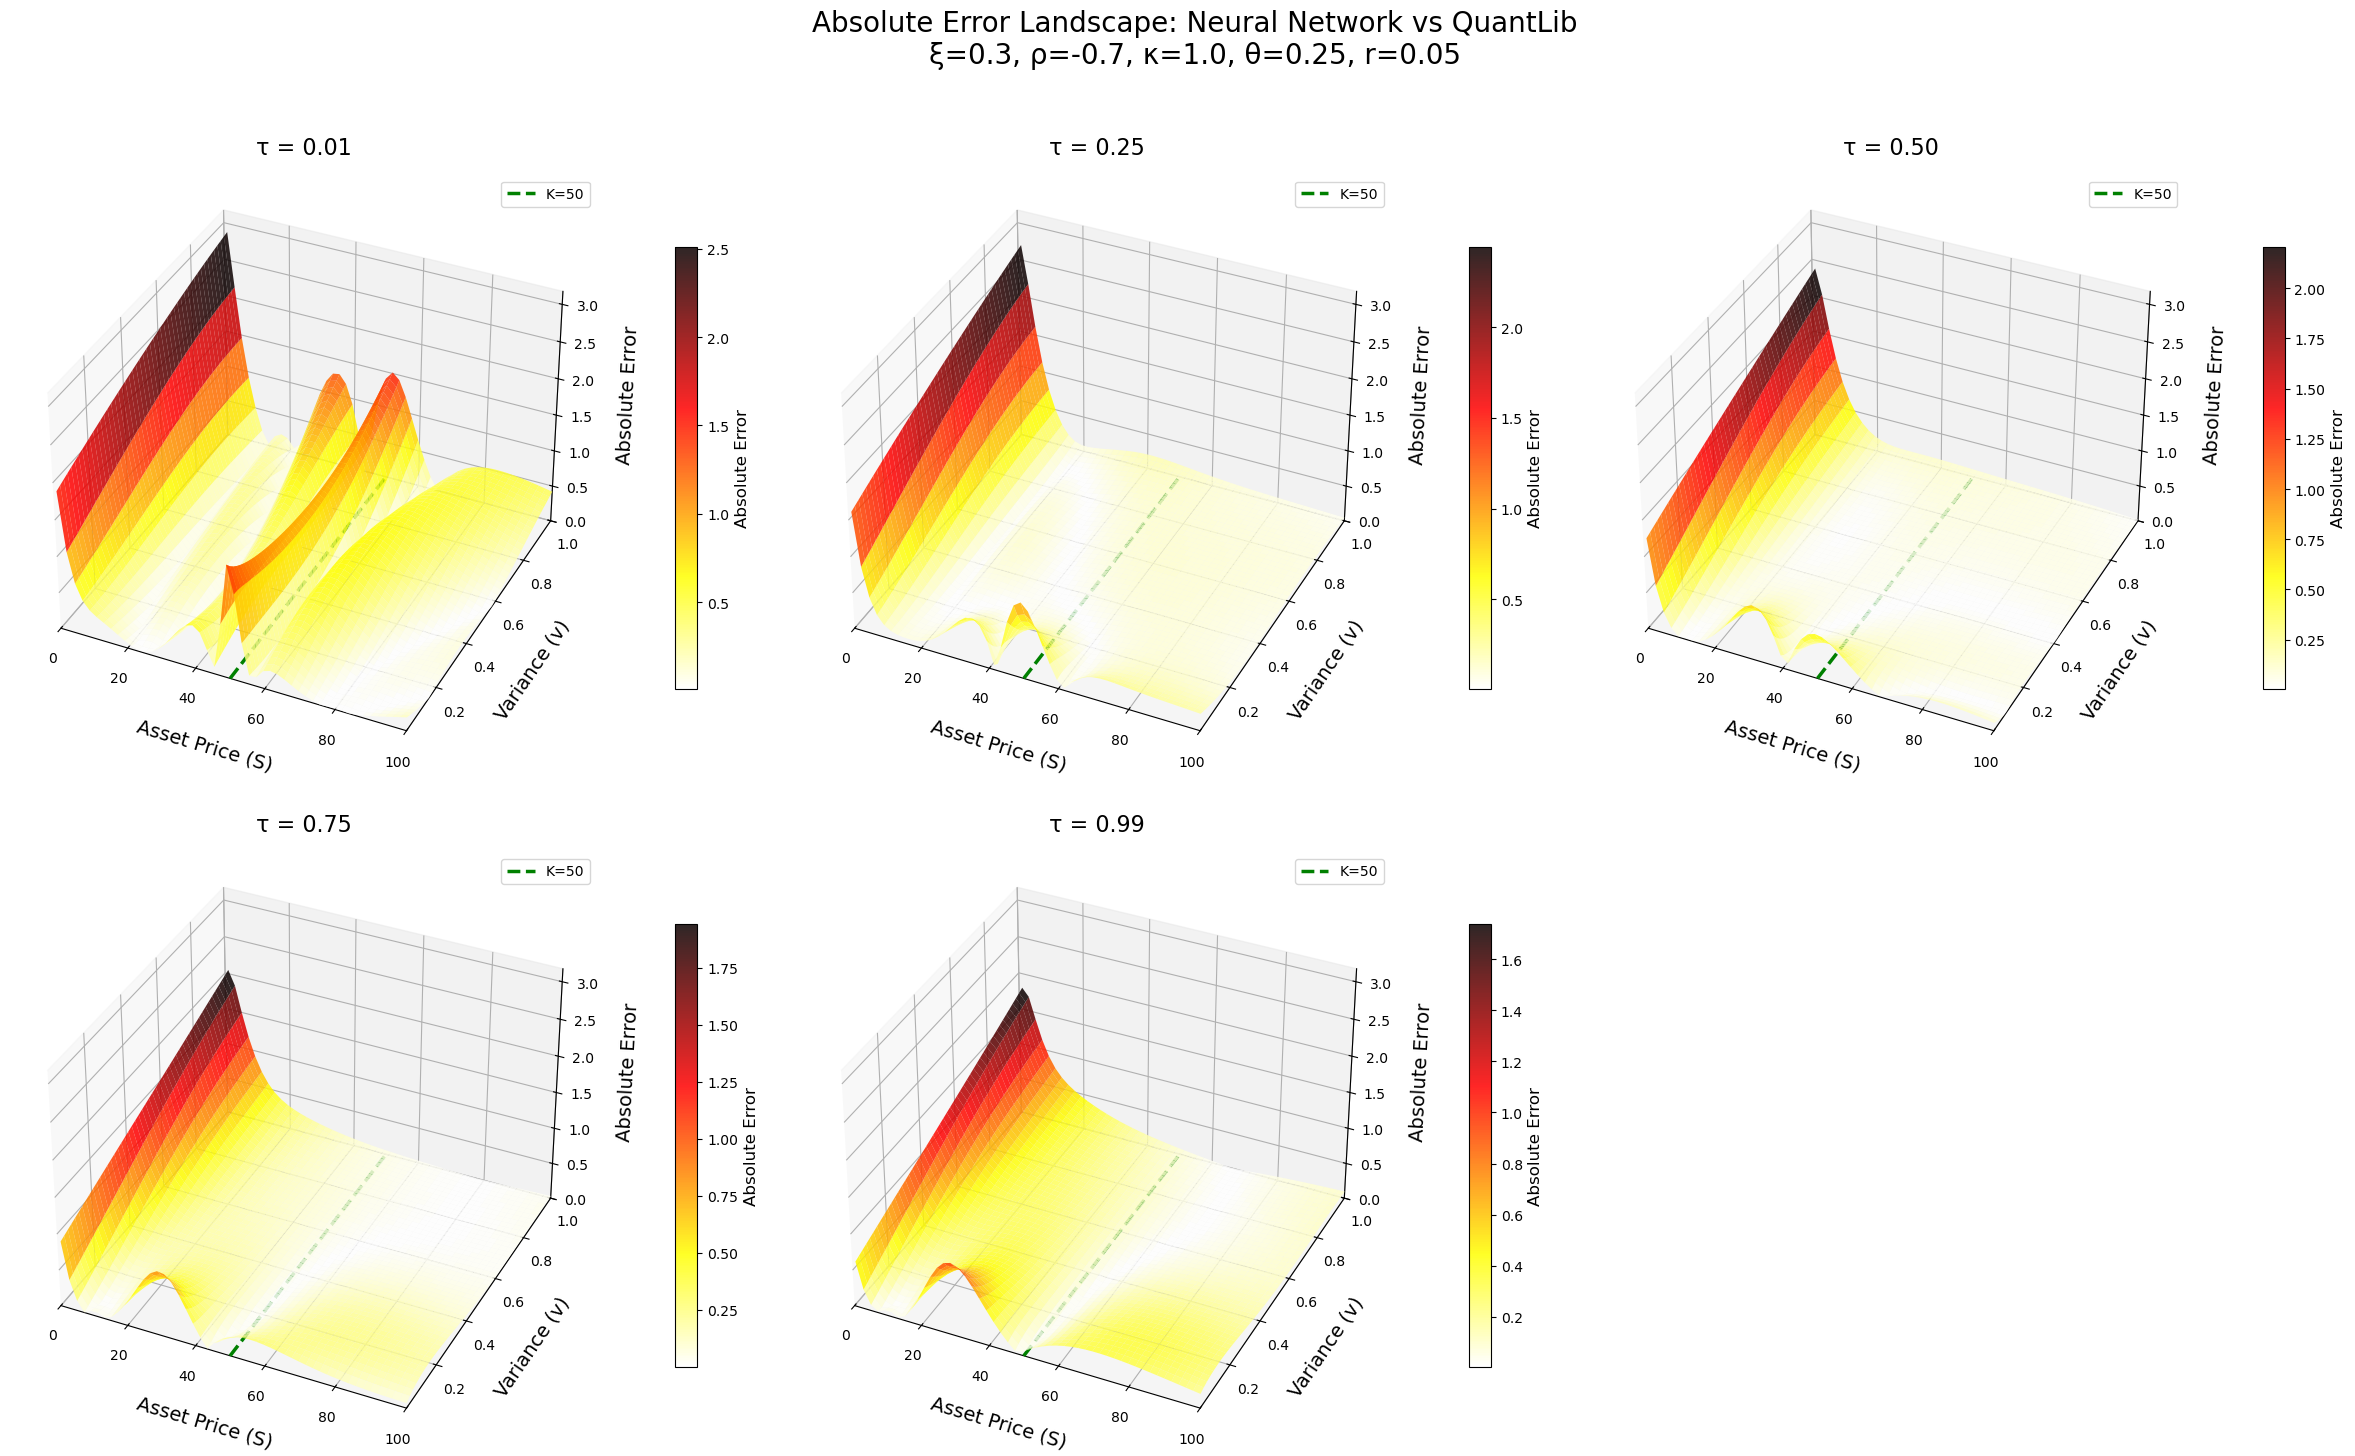

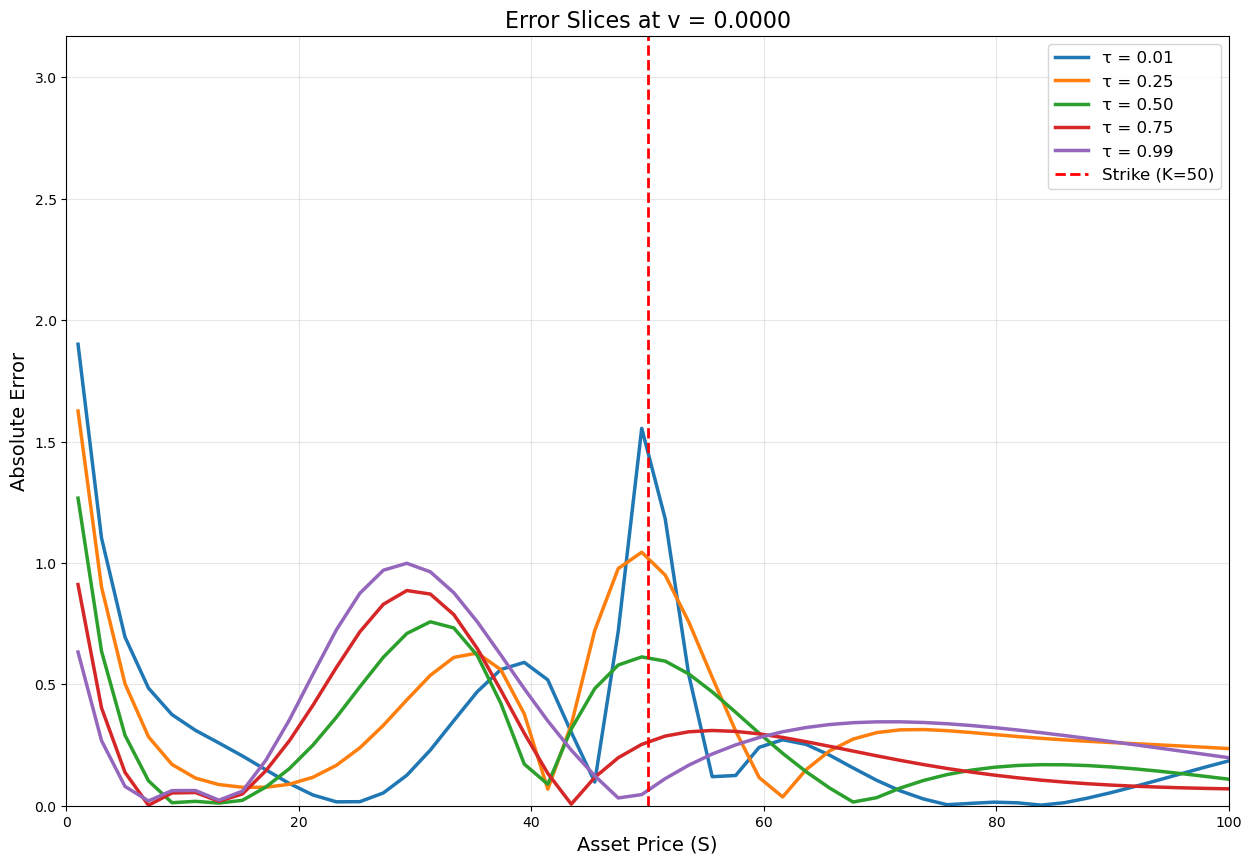

In [1]:
import numpy as np
import tensorflow as tf
import QuantLib as ql
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load saved model
model = tf.keras.models.load_model('heston_model', compile=False)

# Fixed parameters
xi = 0.3  # volatility of volatility
rho = -0.7  # correlation
kappa = 1.0  # mean reversion rate
theta = 0.25  # long-term mean variance
r = 0.05  # risk-free rate

# Time slices
tau_slices = [0.01, 0.25, 0.5, 0.75, 0.99]

# Redefine normalization functions and bounds (from training code)
normalised_max = 1
normalised_min = -1
strike_price = 50

# Bounds from training
s_min_interest = 0.01
s_max_interest = 100
t_min_interest = 0.01
t_max_interest = 1.0
riskfree_rate_min = 0.01
riskfree_rate_max = 0.3
v_min = 0.01
v_max = 1.0
kappa_min = 0.5
kappa_max = 2.0
theta_min = 0.05
theta_max = 0.3
sigma_min = 0.1
sigma_max = 0.5

# Time bounds
t_min = 0.0
t_max = t_max_interest

# Asset price bounds
s_max = strike_price * (1 + 3 * np.sqrt(v_max) * t_max)
x_max = np.log(s_max)
x_min = 2 * np.log(strike_price) - x_max

# Transformation functions
def transform_ab_to_cd(x, a, b, c, d): 
    return c + (x-a) * (d-c) / (b-a)

def normalise_logprice(x):
    return transform_ab_to_cd(x, x_min, x_max, normalised_min, normalised_max)

def normalise_time(tau): 
    return transform_ab_to_cd(tau, t_min, t_max, normalised_min, normalised_max)

def normalise_riskfree_rate(r):
    return transform_ab_to_cd(r, riskfree_rate_min, riskfree_rate_max, 
                             normalised_min, normalised_max)

def normalise_variance(v):
    return transform_ab_to_cd(v, v_min, v_max, normalised_min, normalised_max)

def normalise_kappa(kappa):
    return transform_ab_to_cd(kappa, kappa_min, kappa_max, normalised_min, normalised_max)

def normalise_theta(theta):
    return transform_ab_to_cd(theta, theta_min, theta_max, normalised_min, normalised_max)

def normalise_sigma(sigma):
    return transform_ab_to_cd(sigma, sigma_min, sigma_max, normalised_min, normalised_max)

# Create grids for S and variance
n_points = 50
s_grid = np.linspace(1, s_max_interest, n_points)  # Start from 1 to avoid 0
v_grid = np.linspace(v_min, v_max, n_points) 
S_mesh, V_mesh = np.meshgrid(s_grid, v_grid, indexing='ij') 

# Setup for QuantLib
fixed_date = ql.Date(15, ql.May, 2023)
ql.Settings.instance().evaluationDate = fixed_date

global_max_error = 0
error_surfaces = []

# Precompute all error surfaces
print("Computing error surfaces...")
for tau_idx, tau in enumerate(tau_slices):
    print(f"Processing τ = {tau:.2f}")
    
    # Flatten meshes for processing
    s_flat = S_mesh.ravel(order='C')
    v_flat = V_mesh.ravel(order='C')  # Variance values
    n_samples = len(s_flat)
    
    # Normalize inputs for neural network
    tau_norm = normalise_time(tau) * np.ones(n_samples)
    x_norm = normalise_logprice(np.log(s_flat))
    v_norm = normalise_variance(v_flat)
    r_norm = normalise_riskfree_rate(r) * np.ones(n_samples)
    kappa_norm = normalise_kappa(kappa) * np.ones(n_samples)
    theta_norm = normalise_theta(theta) * np.ones(n_samples)
    sigma_norm = normalise_sigma(xi) * np.ones(n_samples)
    
    # Create input array for model
    X_test = np.column_stack([tau_norm, x_norm, v_norm, r_norm, kappa_norm, theta_norm, sigma_norm])
    
    # Model predictions
    model_predictions = model.predict(X_test, verbose=0).flatten()
    
    # Compute true prices with QuantLib
    true_prices = []
    
    for i in range(n_samples):
        # Calculate maturity date
        maturity_date = fixed_date + ql.Period(int(tau*365), ql.Days)
        
        # Create option
        exercise = ql.EuropeanExercise(maturity_date)
        payoff = ql.PlainVanillaPayoff(ql.Option.Call, strike_price)
        option = ql.VanillaOption(payoff, exercise)
        
        # Setup market data
        underlying = ql.SimpleQuote(s_flat[i])
        dividend_yield = ql.FlatForward(fixed_date, 0.0, ql.Actual365Fixed())
        risk_free_rate = ql.FlatForward(fixed_date, r, ql.Actual365Fixed())
        
        # Create Heston process (uses variance v_flat[i])
        heston_process = ql.HestonProcess(ql.YieldTermStructureHandle(risk_free_rate), ql.YieldTermStructureHandle(dividend_yield), ql.QuoteHandle(underlying),
            v_flat[i],  # variance input
            kappa, theta, xi, rho)
        
        # Price option
        heston_model = ql.HestonModel(heston_process)
        option.setPricingEngine(ql.AnalyticHestonEngine(heston_model))
        
        try:
            price = option.NPV()
            true_prices.append(price)
        except RuntimeError:
            true_prices.append(np.nan)
    
    # Calculate absolute errors
    true_prices = np.array(true_prices)
    abs_errors = np.abs(model_predictions - true_prices)
    
    # Update global max error
    current_max_error = np.nanmax(abs_errors)
    global_max_error = max(global_max_error, current_max_error)
    
    # Reshape for plotting
    error_mesh = abs_errors.reshape(S_mesh.shape)
    error_surfaces.append(error_mesh)

# Create figure with subplots
fig = plt.figure(figsize=(24, 16))
fig.suptitle('Absolute Error Landscape: Neural Network vs QuantLib\n' + 
             f'ξ={xi}, ρ={rho}, κ={kappa}, θ={theta}, r={r}', 
             fontsize=20, y=0.95)

# Create subplots for each tau
for i, tau in enumerate(tau_slices):
    ax = fig.add_subplot(2, 3, i+1, projection='3d')
    error_grid = error_surfaces[i]
    
    # Plot error surface 
    surf = ax.plot_surface(S_mesh, V_mesh, error_grid, cmap='hot_r', rstride=1, cstride=1, alpha=0.85, edgecolor='none', antialiased=True) 
    ax.set_xlabel('Asset Price (S)', fontsize=14, labelpad=12)
    ax.set_ylabel('Variance (v)', fontsize=14, labelpad=12) 
    ax.set_zlabel('Absolute Error', fontsize=14, labelpad=12)
    ax.set_title(f'τ = {tau:.2f}', fontsize=16, pad=15)
    
    # Viewing angle
    ax.view_init(elev=35, azim=-65)
    
    # Axis limits
    ax.set_xlim(0, s_max_interest)
    ax.set_ylim(v_min, v_max)  
    
    # Consistent z-axis scaling
    ax.set_zlim(0, global_max_error * 1.1)
    
    # Highlight strike price
    ax.plot([strike_price, strike_price], [v_min, v_max], [0, 0], 'g--', linewidth=2.5, label=f'K={strike_price}')
    ax.legend()
    
    # Add grid
    ax.grid(True, linestyle='--', alpha=0.3)
    
    # Colorbar
    cbar = fig.colorbar(surf, ax=ax, shrink=0.6, pad=0.1)
    cbar.set_label('Absolute Error', fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('heston_error_landscape_grid_variance_v0.png', dpi=300, bbox_inches='tight')
plt.show()

# Create 2D error slices at specific V value
target_variance = 0.00
v_idx = np.argmin(np.abs(v_grid - target_variance))

plt.figure(figsize=(15, 10))
for i, tau in enumerate(tau_slices):
    error_slice = error_surfaces[i][:, v_idx]
    plt.plot(s_grid, error_slice, linewidth=2.5, label=f'τ = {tau:.2f}')

plt.axvline(x=strike_price, color='r', linestyle='--', linewidth=2, label=f'Strike (K={strike_price})')
plt.xlabel('Asset Price (S)', fontsize=14)
plt.ylabel('Absolute Error', fontsize=14)
plt.title(f'Error Slices at v = {target_variance:.4f}', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xlim(0, s_max_interest)
plt.ylim(0, global_max_error * 1.1)
plt.savefig('heston_error_slices_variance_v0.png', dpi=300, bbox_inches='tight')
plt.show()

Computing error surfaces...
Processing τ = 0.01
Processing τ = 0.25
Processing τ = 0.50
Processing τ = 0.75
Processing τ = 0.99


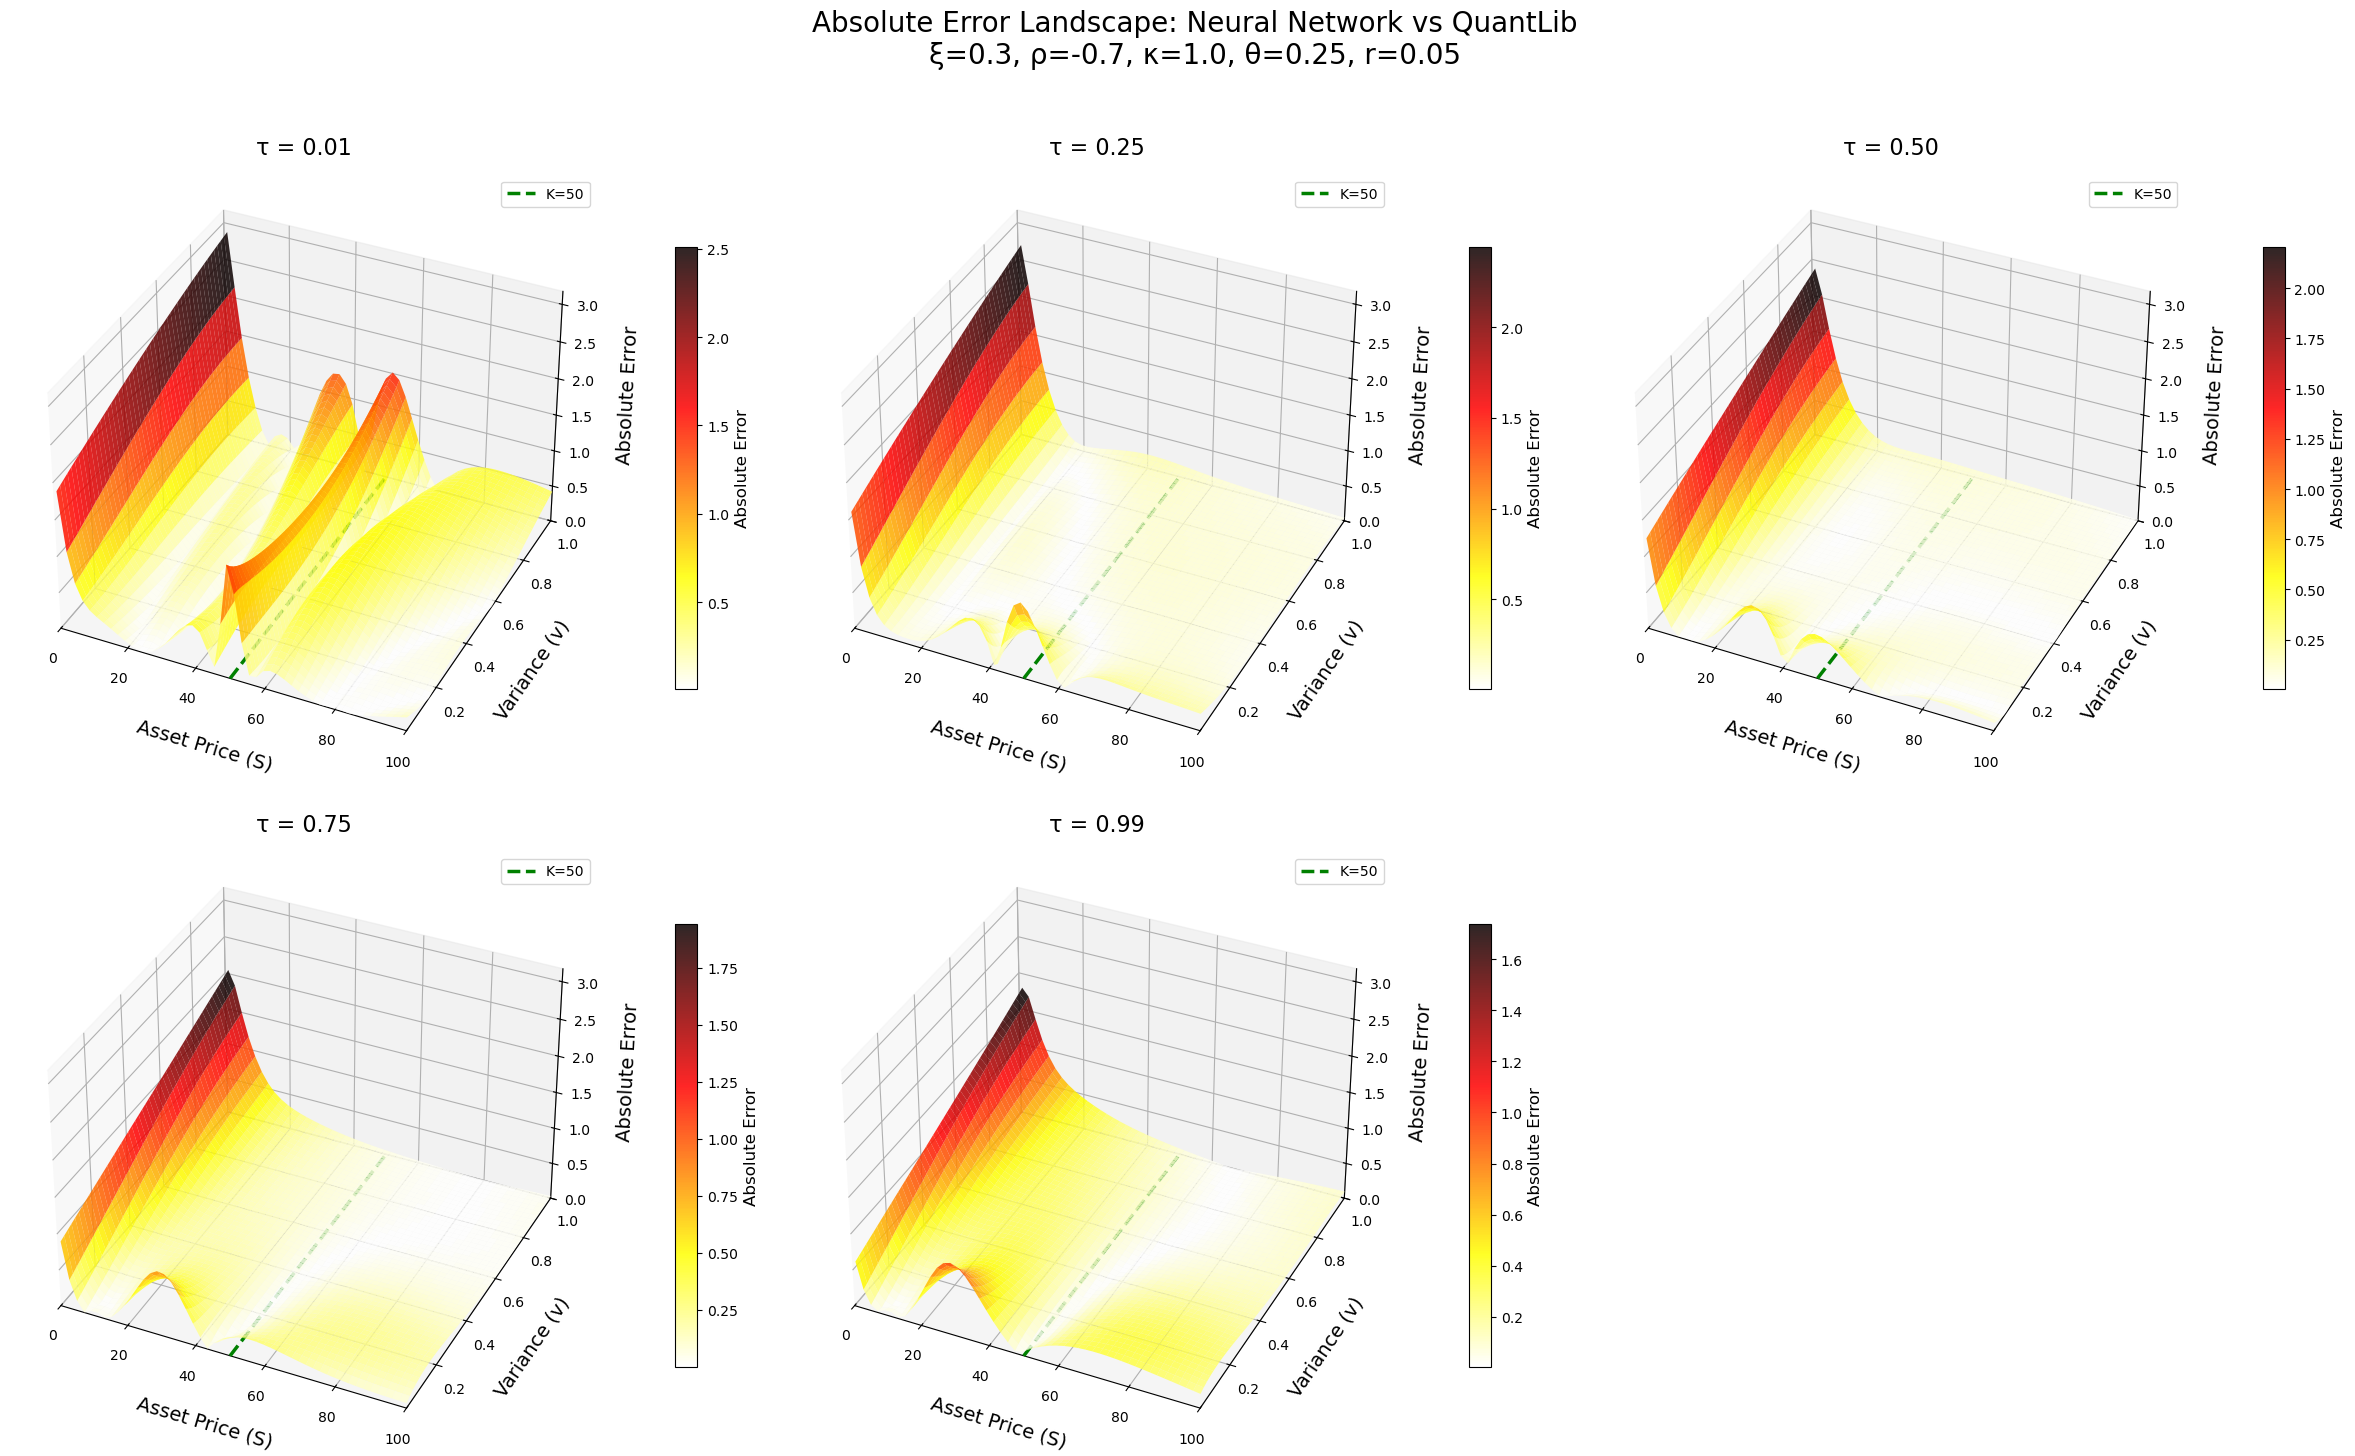

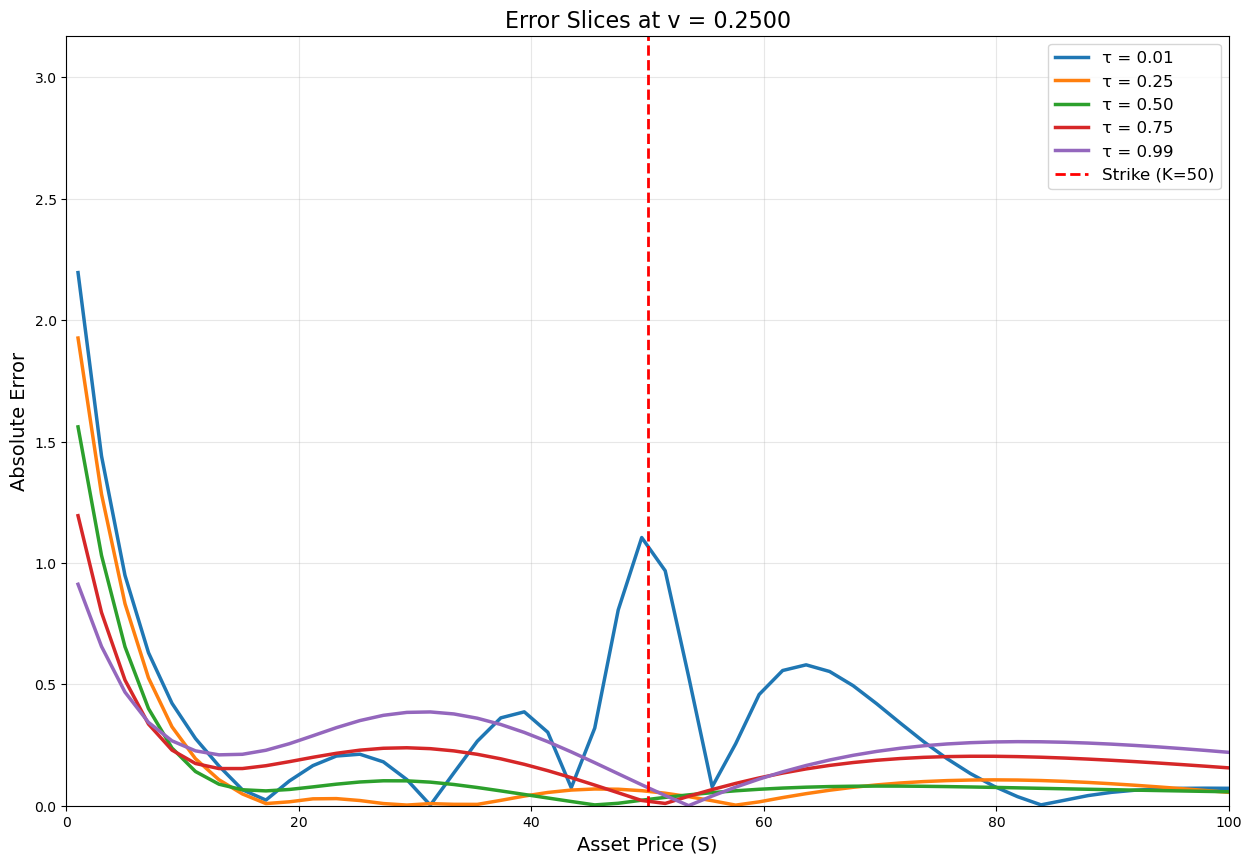

In [2]:
import numpy as np
import tensorflow as tf
import QuantLib as ql
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load saved model
model = tf.keras.models.load_model('heston_model', compile=False)

# Fixed parameters
xi = 0.3  # volatility of volatility
rho = -0.7  # correlation
kappa = 1.0  # mean reversion rate
theta = 0.25  # long-term mean variance
r = 0.05  # risk-free rate

# Time slices
tau_slices = [0.01, 0.25, 0.5, 0.75, 0.99]

# Redefine normalization functions and bounds (from training code)
normalised_max = 1
normalised_min = -1
strike_price = 50

# Bounds from training
s_min_interest = 0.01
s_max_interest = 100
t_min_interest = 0.01
t_max_interest = 1.0
riskfree_rate_min = 0.01
riskfree_rate_max = 0.3
v_min = 0.01
v_max = 1.0
kappa_min = 0.5
kappa_max = 2.0
theta_min = 0.05
theta_max = 0.3
sigma_min = 0.1
sigma_max = 0.5

# Time bounds
t_min = 0.0
t_max = t_max_interest

# Asset price bounds
s_max = strike_price * (1 + 3 * np.sqrt(v_max) * t_max)
x_max = np.log(s_max)
x_min = 2 * np.log(strike_price) - x_max

# Transformation functions
def transform_ab_to_cd(x, a, b, c, d): 
    return c + (x-a) * (d-c) / (b-a)

def normalise_logprice(x):
    return transform_ab_to_cd(x, x_min, x_max, normalised_min, normalised_max)

def normalise_time(tau): 
    return transform_ab_to_cd(tau, t_min, t_max, normalised_min, normalised_max)

def normalise_riskfree_rate(r):
    return transform_ab_to_cd(r, riskfree_rate_min, riskfree_rate_max, 
                             normalised_min, normalised_max)

def normalise_variance(v):
    return transform_ab_to_cd(v, v_min, v_max, normalised_min, normalised_max)

def normalise_kappa(kappa):
    return transform_ab_to_cd(kappa, kappa_min, kappa_max, normalised_min, normalised_max)

def normalise_theta(theta):
    return transform_ab_to_cd(theta, theta_min, theta_max, normalised_min, normalised_max)

def normalise_sigma(sigma):
    return transform_ab_to_cd(sigma, sigma_min, sigma_max, normalised_min, normalised_max)

# Create grids for S and variance
n_points = 50
s_grid = np.linspace(1, s_max_interest, n_points)  # Start from 1 to avoid 0
v_grid = np.linspace(v_min, v_max, n_points) 
S_mesh, V_mesh = np.meshgrid(s_grid, v_grid, indexing='ij') 

# Setup for QuantLib
fixed_date = ql.Date(15, ql.May, 2023)
ql.Settings.instance().evaluationDate = fixed_date

global_max_error = 0
error_surfaces = []

# Precompute all error surfaces
print("Computing error surfaces...")
for tau_idx, tau in enumerate(tau_slices):
    print(f"Processing τ = {tau:.2f}")
    
    # Flatten meshes for processing
    s_flat = S_mesh.ravel(order='C')
    v_flat = V_mesh.ravel(order='C')  # Variance values
    n_samples = len(s_flat)
    
    # Normalize inputs for neural network
    tau_norm = normalise_time(tau) * np.ones(n_samples)
    x_norm = normalise_logprice(np.log(s_flat))
    v_norm = normalise_variance(v_flat)
    r_norm = normalise_riskfree_rate(r) * np.ones(n_samples)
    kappa_norm = normalise_kappa(kappa) * np.ones(n_samples)
    theta_norm = normalise_theta(theta) * np.ones(n_samples)
    sigma_norm = normalise_sigma(xi) * np.ones(n_samples)
    
    # Create input array for model
    X_test = np.column_stack([tau_norm, x_norm, v_norm, r_norm, kappa_norm, theta_norm, sigma_norm])
    
    # Model predictions
    model_predictions = model.predict(X_test, verbose=0).flatten()
    
    # Compute true prices with QuantLib
    true_prices = []
    
    for i in range(n_samples):
        # Calculate maturity date
        maturity_date = fixed_date + ql.Period(int(tau*365), ql.Days)
        
        # Create option
        exercise = ql.EuropeanExercise(maturity_date)
        payoff = ql.PlainVanillaPayoff(ql.Option.Call, strike_price)
        option = ql.VanillaOption(payoff, exercise)
        
        # Setup market data
        underlying = ql.SimpleQuote(s_flat[i])
        dividend_yield = ql.FlatForward(fixed_date, 0.0, ql.Actual365Fixed())
        risk_free_rate = ql.FlatForward(fixed_date, r, ql.Actual365Fixed())
        
        # Create Heston process (uses variance v_flat[i])
        heston_process = ql.HestonProcess(ql.YieldTermStructureHandle(risk_free_rate), ql.YieldTermStructureHandle(dividend_yield), ql.QuoteHandle(underlying),
            v_flat[i],  # variance input
            kappa, theta, xi, rho)
        
        # Price option
        heston_model = ql.HestonModel(heston_process)
        option.setPricingEngine(ql.AnalyticHestonEngine(heston_model))
        
        try:
            price = option.NPV()
            true_prices.append(price)
        except RuntimeError:
            true_prices.append(np.nan)
    
    # Calculate absolute errors
    true_prices = np.array(true_prices)
    abs_errors = np.abs(model_predictions - true_prices)
    
    # Update global max error
    current_max_error = np.nanmax(abs_errors)
    global_max_error = max(global_max_error, current_max_error)
    
    # Reshape for plotting
    error_mesh = abs_errors.reshape(S_mesh.shape)
    error_surfaces.append(error_mesh)

# Create figure with subplots
fig = plt.figure(figsize=(24, 16))
fig.suptitle('Absolute Error Landscape: Neural Network vs QuantLib\n' + 
             f'ξ={xi}, ρ={rho}, κ={kappa}, θ={theta}, r={r}', 
             fontsize=20, y=0.95)

# Create subplots for each tau
for i, tau in enumerate(tau_slices):
    ax = fig.add_subplot(2, 3, i+1, projection='3d')
    error_grid = error_surfaces[i]
    
    # Plot error surface 
    surf = ax.plot_surface(S_mesh, V_mesh, error_grid, cmap='hot_r', rstride=1, cstride=1, alpha=0.85, edgecolor='none', antialiased=True) 
    ax.set_xlabel('Asset Price (S)', fontsize=14, labelpad=12)
    ax.set_ylabel('Variance (v)', fontsize=14, labelpad=12) 
    ax.set_zlabel('Absolute Error', fontsize=14, labelpad=12)
    ax.set_title(f'τ = {tau:.2f}', fontsize=16, pad=15)
    
    # Viewing angle
    ax.view_init(elev=35, azim=-65)
    
    # Axis limits
    ax.set_xlim(0, s_max_interest)
    ax.set_ylim(v_min, v_max)  
    
    # Consistent z-axis scaling
    ax.set_zlim(0, global_max_error * 1.1)
    
    # Highlight strike price
    ax.plot([strike_price, strike_price], [v_min, v_max], [0, 0], 'g--', linewidth=2.5, label=f'K={strike_price}')
    ax.legend()
    
    # Add grid
    ax.grid(True, linestyle='--', alpha=0.3)
    
    # Colorbar
    cbar = fig.colorbar(surf, ax=ax, shrink=0.6, pad=0.1)
    cbar.set_label('Absolute Error', fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('heston_error_landscape_grid_variance_v0.png', dpi=300, bbox_inches='tight')
plt.show()

# Create 2D error slices at specific V value
target_variance = 0.25
v_idx = np.argmin(np.abs(v_grid - target_variance))

plt.figure(figsize=(15, 10))
for i, tau in enumerate(tau_slices):
    error_slice = error_surfaces[i][:, v_idx]
    plt.plot(s_grid, error_slice, linewidth=2.5, label=f'τ = {tau:.2f}')

plt.axvline(x=strike_price, color='r', linestyle='--', linewidth=2, label=f'Strike (K={strike_price})')
plt.xlabel('Asset Price (S)', fontsize=14)
plt.ylabel('Absolute Error', fontsize=14)
plt.title(f'Error Slices at v = {target_variance:.4f}', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xlim(0, s_max_interest)
plt.ylim(0, global_max_error * 1.1)
plt.savefig('heston_error_slices_variance_v0.png', dpi=300, bbox_inches='tight')
plt.show()

---